# Disaster Tweet Mini-Project
Zhen Lian

## Overview
The goal of this project is to build a classifier which identifies tweets related to disasters. The dataset used in this project is from Kaggle competition "Natural Language Processing with Disaster Tweets" (https://www.kaggle.com/c/nlp-getting-started/overview). Link to GitHub repository: https://github.com/zlianrpi/disaster-tweet-mini-project.git.

## Exploratory data analysis
First let us load the data into a DataFrame and inspect the data.

In [84]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [76]:
df = pd.read_csv('train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Checking the information about the dataframe and visualizing the lengths of tweets.

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text, dtype: float64

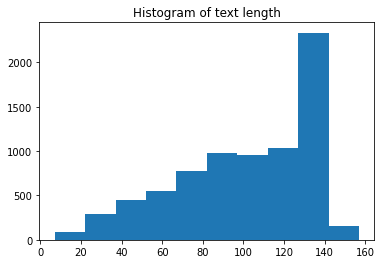

In [88]:
text_lengths = df['text'].str.len()
plt.hist(text_lengths)
plt.title('Histogram of text length')
text_lengths.describe()

The dataset contains information about 7613 tweets. Text and label contain no null values. Other columns contain some null values. Text length has a mean of 101 and a standard deviation of 34. 

Next let us take a random sample from the dataset and check the format of the data: 

In [78]:
df.sample(100, random_state=0)

,id,keyword,location,text,target
311,454,armageddon,Wrigley Field,@KatieKatCubs you already know how this shit g...,0
4970,7086,meltdown,Two Up Two Down,@LeMaireLee @danharmon People Near Meltdown Co...,0
527,762,avalanche,Score Team Goals Buying @,1-6 TIX Calgary Flames vs COL Avalanche Presea...,0
6362,9094,suicide%20bomb,Roadside,If you ever think you running out of choices i...,0
800,1160,blight,Laventillemoorings,If you dotish to blight your car go right ahea...,0
...,...,...,...,...,...
1369,1973,bush%20fires,"iPhone: -27.499212,153.011072",@marcoarment Middle of winter in Sydney we hav...,1
7337,10503,wildfire,"Riverside, California.",Is LA at Risk for a Giant Wildfire? - Which Wa...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1
1332,1924,burning%20buildings,"St Charles, MD",I'm mentally preparing myself for a bomb ass s...,0


It seems that the text data in the dataset contains some useless feature, including patterns like "@user_name", web links and special characters. Here I removed those words with regular expression. I also converted all capital letters into lowercase so that the model is not case-sensitive.

In [79]:
df['processed_text'] = df['text'].str.replace('@\w* ', '', case=False, regex=True)
df['processed_text'] = df['processed_text'].str.replace('http[^\s]*', '', case=False, regex=True)
df['processed_text'] = df['processed_text'].str.replace('[^\w\s]', '', regex=True)
df['processed_text'] = df['processed_text'].str.lower()
df

,id,keyword,location,text,target,processed_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,the out of control wild fires in california ev...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...


Here is the code to split the data into train and validation set and load them into tensors.

In [80]:
df_train, df_val = train_test_split(df, random_state=0)

In [81]:
X_train = tf.convert_to_tensor(df_train['processed_text'])
y_train = tf.convert_to_tensor(df_train['target'])
X_val = tf.convert_to_tensor(df_val['processed_text'])
y_val = tf.convert_to_tensor(df_val['target'])

## Model training and evaluation


First we need to define a preprocessing layer which converts the text data into word counts.

In [90]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

Checking the most frequent words

In [91]:
vocab = np.array(encoder.get_vocabulary())
vocab[:100]

array(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for',
       'on', 'you', 'my', 'it', 'with', 'that', 'at', 'by', 'this',
       'from', 'be', 'are', 'have', 'was', 'as', 'up', 'like', 'just',
       'me', 'so', 'but', 'im', 'amp', 'not', 'your', 'has', 'out', 'its',
       'will', 'after', 'no', 'if', 'all', 'fire', 'when', 'an', 'we',
       'now', 'get', 'new', 'via', 'more', 'or', 'about', 'what', 'he',
       'one', 'been', 'news', 'dont', 'they', 'over', 'who', 'were',
       'people', 'how', 'into', 'us', '2', 'emergency', 'do', 'video',
       'there', 'can', 'disaster', 'police', 'would', 'still', 'than',
       'burning', 'his', 'california', 'her', 'crash', 'back', 'body',
       'some', 'off', 'suicide', 'first', 'storm', 'got', 'why', 'cant',
       'buildings', 'rt', 'going', 'fires', 'know'], dtype='<U17')

First let us check a bidirectional LSTM model with 64 units followed by a dense layer with 64 units.

In [142]:
model_lstm_1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Here is a funtion to train the model. Early stopping is used to prevent overfitting.

In [135]:
def train_model(model, lr=1e-4, epochs=20):
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(lr),
              metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,mode="min", restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val),
                    validation_steps=30, callbacks = [callback])
    return history

First, find the optimal learning rate.

In [137]:
train_model(model_lstm_1, lr=1e-3)

Epoch 1/20
179/179 [==============================] - 10s 30ms/step - loss: 0.5514 - accuracy: 0.7145 - val_loss: 0.4745 - val_accuracy: 0.7794
Epoch 2/20
179/179 [==============================] - 3s 17ms/step - loss: 0.4150 - accuracy: 0.8166 - val_loss: 0.4628 - val_accuracy: 0.7857
Epoch 3/20
179/179 [==============================] - 3s 17ms/step - loss: 0.3729 - accuracy: 0.8431 - val_loss: 0.4761 - val_accuracy: 0.7946
Epoch 4/20
179/179 [==============================] - 3s 17ms/step - loss: 0.3333 - accuracy: 0.8604 - val_loss: 0.4955 - val_accuracy: 0.7925
Epoch 5/20
179/179 [==============================] - 3s 17ms/step - loss: 0.2951 - accuracy: 0.8837 - val_loss: 0.5501 - val_accuracy: 0.7805
Epoch 6/20
179/179 [==============================] - 3s 17ms/step - loss: 0.2560 - accuracy: 0.9026 - val_loss: 0.6268 - val_accuracy: 0.7700
Epoch 7/20
179/179 [==============================] - 3s 17ms/step - loss: 0.2234 - accuracy: 0.9119 - val_loss: 0.6757 - val_accuracy: 0.760

In [139]:
train_model(model_lstm_1, lr=1e-4)

Epoch 1/20
179/179 [==============================] - 10s 28ms/step - loss: 0.6867 - accuracy: 0.5624 - val_loss: 0.6739 - val_accuracy: 0.5814
Epoch 2/20
179/179 [==============================] - 3s 17ms/step - loss: 0.6367 - accuracy: 0.6590 - val_loss: 0.5594 - val_accuracy: 0.7784
Epoch 3/20
179/179 [==============================] - 3s 17ms/step - loss: 0.5011 - accuracy: 0.7916 - val_loss: 0.4888 - val_accuracy: 0.7899
Epoch 4/20
179/179 [==============================] - 3s 17ms/step - loss: 0.4395 - accuracy: 0.8224 - val_loss: 0.4710 - val_accuracy: 0.7967
Epoch 5/20
179/179 [==============================] - 3s 17ms/step - loss: 0.4147 - accuracy: 0.8332 - val_loss: 0.4616 - val_accuracy: 0.7988
Epoch 6/20
179/179 [==============================] - 3s 17ms/step - loss: 0.3962 - accuracy: 0.8403 - val_loss: 0.4560 - val_accuracy: 0.8020
Epoch 7/20
179/179 [==============================] - 3s 17ms/step - loss: 0.3842 - accuracy: 0.8452 - val_loss: 0.4660 - val_accuracy: 0.795

In [141]:
train_model(model_lstm_1, lr=1e-5)

Epoch 1/20
179/179 [==============================] - 10s 27ms/step - loss: 0.6919 - accuracy: 0.5665 - val_loss: 0.6908 - val_accuracy: 0.5809
Epoch 2/20
179/179 [==============================] - 3s 17ms/step - loss: 0.6905 - accuracy: 0.5705 - val_loss: 0.6890 - val_accuracy: 0.5814
Epoch 3/20
179/179 [==============================] - 3s 17ms/step - loss: 0.6888 - accuracy: 0.5666 - val_loss: 0.6869 - val_accuracy: 0.5814
Epoch 4/20
179/179 [==============================] - 3s 17ms/step - loss: 0.6871 - accuracy: 0.5666 - val_loss: 0.6848 - val_accuracy: 0.5814
Epoch 5/20
179/179 [==============================] - 3s 17ms/step - loss: 0.6852 - accuracy: 0.5666 - val_loss: 0.6825 - val_accuracy: 0.5814
Epoch 6/20
179/179 [==============================] - 3s 17ms/step - loss: 0.6832 - accuracy: 0.5666 - val_loss: 0.6799 - val_accuracy: 0.5814
Epoch 7/20
179/179 [==============================] - 3s 17ms/step - loss: 0.6809 - accuracy: 0.5668 - val_loss: 0.6773 - val_accuracy: 0.581

In [143]:
# retrain with the best learning rate
history_1 = train_model(model_lstm_1, lr=1e-4)

Epoch 1/20
179/179 [==============================] - 11s 27ms/step - loss: 0.6876 - accuracy: 0.5610 - val_loss: 0.6762 - val_accuracy: 0.5825
Epoch 2/20
179/179 [==============================] - 3s 17ms/step - loss: 0.6446 - accuracy: 0.6476 - val_loss: 0.5620 - val_accuracy: 0.7679
Epoch 3/20
179/179 [==============================] - 3s 17ms/step - loss: 0.5037 - accuracy: 0.7900 - val_loss: 0.4794 - val_accuracy: 0.7962
Epoch 4/20
179/179 [==============================] - 3s 17ms/step - loss: 0.4428 - accuracy: 0.8199 - val_loss: 0.4663 - val_accuracy: 0.7994
Epoch 5/20
179/179 [==============================] - 3s 17ms/step - loss: 0.4136 - accuracy: 0.8331 - val_loss: 0.4545 - val_accuracy: 0.8025
Epoch 6/20
179/179 [==============================] - 3s 17ms/step - loss: 0.3966 - accuracy: 0.8399 - val_loss: 0.4586 - val_accuracy: 0.8030
Epoch 7/20
179/179 [==============================] - 3s 17ms/step - loss: 0.3822 - accuracy: 0.8464 - val_loss: 0.4569 - val_accuracy: 0.804

In [149]:
# change parameters by adding more units to LSTM
model_lstm_2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [150]:
history_2 = train_model(model_lstm_2)

Epoch 1/20
179/179 [==============================] - 11s 29ms/step - loss: 0.6798 - accuracy: 0.5772 - val_loss: 0.6411 - val_accuracy: 0.7048
Epoch 2/20
179/179 [==============================] - 3s 18ms/step - loss: 0.5460 - accuracy: 0.7648 - val_loss: 0.4903 - val_accuracy: 0.7815
Epoch 3/20
179/179 [==============================] - 3s 18ms/step - loss: 0.4485 - accuracy: 0.8124 - val_loss: 0.4661 - val_accuracy: 0.7915
Epoch 4/20
179/179 [==============================] - 3s 19ms/step - loss: 0.4115 - accuracy: 0.8299 - val_loss: 0.4625 - val_accuracy: 0.7883
Epoch 5/20
179/179 [==============================] - 3s 18ms/step - loss: 0.3895 - accuracy: 0.8383 - val_loss: 0.4731 - val_accuracy: 0.7967
Epoch 6/20
179/179 [==============================] - 3s 19ms/step - loss: 0.3753 - accuracy: 0.8457 - val_loss: 0.4746 - val_accuracy: 0.7941
Epoch 7/20
179/179 [==============================] - 3s 18ms/step - loss: 0.3637 - accuracy: 0.8522 - val_loss: 0.4680 - val_accuracy: 0.797

In [152]:
# adding more units to dense layer
model_lstm_3 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [153]:
history_3 = train_model(model_lstm_3)

Epoch 1/20
179/179 [==============================] - 10s 27ms/step - loss: 0.6859 - accuracy: 0.5672 - val_loss: 0.6702 - val_accuracy: 0.5961
Epoch 2/20
179/179 [==============================] - 3s 17ms/step - loss: 0.5929 - accuracy: 0.7056 - val_loss: 0.5169 - val_accuracy: 0.7600
Epoch 3/20
179/179 [==============================] - 3s 17ms/step - loss: 0.4696 - accuracy: 0.7993 - val_loss: 0.4750 - val_accuracy: 0.7820
Epoch 4/20
179/179 [==============================] - 3s 17ms/step - loss: 0.4238 - accuracy: 0.8205 - val_loss: 0.4572 - val_accuracy: 0.7952
Epoch 5/20
179/179 [==============================] - 3s 17ms/step - loss: 0.3986 - accuracy: 0.8318 - val_loss: 0.4546 - val_accuracy: 0.7983
Epoch 6/20
179/179 [==============================] - 3s 17ms/step - loss: 0.3802 - accuracy: 0.8401 - val_loss: 0.4572 - val_accuracy: 0.8025
Epoch 7/20
179/179 [==============================] - 3s 17ms/step - loss: 0.3672 - accuracy: 0.8446 - val_loss: 0.4622 - val_accuracy: 0.803

In [154]:
#reducing units in dense layer
model_lstm_4 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
history_4 = train_model(model_lstm_4)

Epoch 1/20
179/179 [==============================] - 10s 27ms/step - loss: 0.6853 - accuracy: 0.5665 - val_loss: 0.6706 - val_accuracy: 0.5814
Epoch 2/20
179/179 [==============================] - 3s 17ms/step - loss: 0.6342 - accuracy: 0.6625 - val_loss: 0.5777 - val_accuracy: 0.7721
Epoch 3/20
179/179 [==============================] - 3s 17ms/step - loss: 0.5285 - accuracy: 0.7900 - val_loss: 0.5063 - val_accuracy: 0.7763
Epoch 4/20
179/179 [==============================] - 3s 17ms/step - loss: 0.4545 - accuracy: 0.8154 - val_loss: 0.4786 - val_accuracy: 0.7836
Epoch 5/20
179/179 [==============================] - 3s 17ms/step - loss: 0.4230 - accuracy: 0.8283 - val_loss: 0.4658 - val_accuracy: 0.7978
Epoch 6/20
179/179 [==============================] - 3s 17ms/step - loss: 0.4014 - accuracy: 0.8389 - val_loss: 0.4670 - val_accuracy: 0.7920
Epoch 7/20
179/179 [==============================] - 3s 17ms/step - loss: 0.3861 - accuracy: 0.8453 - val_loss: 0.4775 - val_accuracy: 0.786

Summary of LSTM models


|model name| units in LSTM | units in dense layer| validation accuracy|
|---|---|---|---|
|model_lstm_1|64|64|0.8088|
|model_lstm_2|128|64| 0.7978|
|model_lstm_3|64|128|0.8036|
|model_lstm_4|64|32|0.8004|



Now try the GRU architecture

In [160]:
model_gru_1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
history_gru1 = train_model(model_gru_1)

Epoch 1/20
179/179 [==============================] - 9s 25ms/step - loss: 0.6842 - accuracy: 0.5663 - val_loss: 0.6737 - val_accuracy: 0.5814
Epoch 2/20
179/179 [==============================] - 3s 15ms/step - loss: 0.6404 - accuracy: 0.6285 - val_loss: 0.5841 - val_accuracy: 0.7216
Epoch 3/20
179/179 [==============================] - 3s 15ms/step - loss: 0.4959 - accuracy: 0.7872 - val_loss: 0.4783 - val_accuracy: 0.7889
Epoch 4/20
179/179 [==============================] - 3s 15ms/step - loss: 0.4234 - accuracy: 0.8210 - val_loss: 0.4643 - val_accuracy: 0.7920
Epoch 5/20
179/179 [==============================] - 3s 15ms/step - loss: 0.3987 - accuracy: 0.8275 - val_loss: 0.4666 - val_accuracy: 0.7836
Epoch 6/20
179/179 [==============================] - 3s 15ms/step - loss: 0.3795 - accuracy: 0.8385 - val_loss: 0.4806 - val_accuracy: 0.7778
Epoch 7/20
179/179 [==============================] - 3s 15ms/step - loss: 0.3677 - accuracy: 0.8474 - val_loss: 0.4691 - val_accuracy: 0.7862

In [161]:
model_gru_2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
history_gru2 = train_model(model_gru_2)

Epoch 1/20
179/179 [==============================] - 10s 27ms/step - loss: 0.6804 - accuracy: 0.5689 - val_loss: 0.6619 - val_accuracy: 0.5924
Epoch 2/20
179/179 [==============================] - 3s 16ms/step - loss: 0.5696 - accuracy: 0.7246 - val_loss: 0.5120 - val_accuracy: 0.7579
Epoch 3/20
179/179 [==============================] - 3s 16ms/step - loss: 0.4438 - accuracy: 0.8078 - val_loss: 0.4849 - val_accuracy: 0.7721
Epoch 4/20
179/179 [==============================] - 3s 16ms/step - loss: 0.4031 - accuracy: 0.8283 - val_loss: 0.4909 - val_accuracy: 0.7726
Epoch 5/20
179/179 [==============================] - 3s 15ms/step - loss: 0.3808 - accuracy: 0.8390 - val_loss: 0.4780 - val_accuracy: 0.7820
Epoch 6/20
179/179 [==============================] - 3s 16ms/step - loss: 0.3671 - accuracy: 0.8422 - val_loss: 0.4740 - val_accuracy: 0.7857
Epoch 7/20
179/179 [==============================] - 3s 16ms/step - loss: 0.3591 - accuracy: 0.8471 - val_loss: 0.4990 - val_accuracy: 0.776

In [162]:
model_gru_3 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
history_gru3 = train_model(model_gru_3)

Epoch 1/20
179/179 [==============================] - 10s 25ms/step - loss: 0.6859 - accuracy: 0.5623 - val_loss: 0.6754 - val_accuracy: 0.5814
Epoch 2/20
179/179 [==============================] - 3s 14ms/step - loss: 0.6489 - accuracy: 0.6255 - val_loss: 0.5785 - val_accuracy: 0.7390
Epoch 3/20
179/179 [==============================] - 3s 14ms/step - loss: 0.4893 - accuracy: 0.7840 - val_loss: 0.4900 - val_accuracy: 0.7763
Epoch 4/20
179/179 [==============================] - 3s 14ms/step - loss: 0.4273 - accuracy: 0.8164 - val_loss: 0.4698 - val_accuracy: 0.7768
Epoch 5/20
179/179 [==============================] - 3s 14ms/step - loss: 0.3992 - accuracy: 0.8329 - val_loss: 0.4703 - val_accuracy: 0.7883
Epoch 6/20
179/179 [==============================] - 3s 15ms/step - loss: 0.3829 - accuracy: 0.8353 - val_loss: 0.4662 - val_accuracy: 0.7841
Epoch 7/20
179/179 [==============================] - 3s 15ms/step - loss: 0.3676 - accuracy: 0.8459 - val_loss: 0.4724 - val_accuracy: 0.786

In [163]:
model_gru_4 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
history_gru4 = train_model(model_gru_4)

Epoch 1/20
179/179 [==============================] - 10s 25ms/step - loss: 0.6871 - accuracy: 0.5582 - val_loss: 0.6763 - val_accuracy: 0.5814
Epoch 2/20
179/179 [==============================] - 3s 14ms/step - loss: 0.6538 - accuracy: 0.6178 - val_loss: 0.5983 - val_accuracy: 0.7279
Epoch 3/20
179/179 [==============================] - 3s 15ms/step - loss: 0.5137 - accuracy: 0.7819 - val_loss: 0.5135 - val_accuracy: 0.7458
Epoch 4/20
179/179 [==============================] - 3s 15ms/step - loss: 0.4380 - accuracy: 0.8129 - val_loss: 0.4727 - val_accuracy: 0.7862
Epoch 5/20
179/179 [==============================] - 3s 15ms/step - loss: 0.4066 - accuracy: 0.8310 - val_loss: 0.4725 - val_accuracy: 0.7868
Epoch 6/20
179/179 [==============================] - 3s 15ms/step - loss: 0.3916 - accuracy: 0.8362 - val_loss: 0.4638 - val_accuracy: 0.7925
Epoch 7/20
179/179 [==============================] - 3s 15ms/step - loss: 0.3761 - accuracy: 0.8439 - val_loss: 0.4647 - val_accuracy: 0.785

Summary of GRU models:

|model name| units in LSTM | units in dense layer| validation accuracy|
|---|---|---|---|
|model_gru_1|64|64|0.7920|
|model_gru_2|128|64| 0.7857|
|model_gru_3|64|128|0.7883|
|model_gru_4|64|32|0.7925|

## Conclusion
Overall I find the LSTM model 1 performs slightly better. Also I noticed that changing model architecture has very limited impact on the validation accuracy. So the bottleneck might be data preprocessing. Using preprocessing techniques such as lemmatization might further improve model performance.

## Create submission file

In [168]:
df_test = pd.read_csv('test.csv')
df_test['processed_text'] = df_test['text'].str.replace('@\w* ', '', case=False, regex=True)
df_test['processed_text'] = df_test['processed_text'].str.replace('http[^\s]*', '', case=False, regex=True)
df_test['processed_text'] = df_test['processed_text'].str.replace('[^\w\s]', '', regex=True)
df_test['processed_text'] = df_test['processed_text'].str.lower()
X_test = tf.convert_to_tensor(df_test['processed_text'])
yprob_test = model_lstm_1.predict(X_test)

102/102 [==============================] - 1s 7ms/step


In [177]:
yclass_test = np.zeros_like(yprob_test)
yclass_test[yprob_test>0.5] = 1
yclass_test = yclass_test.astype(np.int32).reshape([-1])
ids = df_test['id'].to_numpy()
submission_df = pd.DataFrame(np.array([ids, yclass_test]).T, columns=['id', 'target'])
submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [178]:
submission_df.to_csv('submission.csv', index=False)